<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/starDist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Preprocessing**

Make a simple category for the GAIA dataset

In [0]:
import glob
import pandas as pd
import numpy as np

#!unzip -q "/content/gaia_pos.zip"
# Get data file names
path =r'/content/gaia_pos'
filenames = glob.glob(path + "/*.csv")

dfs = []
error_dfs = []

# Select specific colomns which are "ra", "dec", "magnitude", "wavelength" and "parallax" and "parallax error"

for filename in filenames:
  data = pd.read_csv(filename, header=None)
  select_data = data.iloc[1:,[2, 4, 10, 11, 6]]
  parallax_error = data.iloc[1:,[7]]
  
  dfs.append(select_data)
  error_dfs.append(parallax_error)

# Combine the three files of the different type of filter into one pandas framework

frame = pd.concat(dfs, axis=0, ignore_index=True, sort = False)
parallax_error_frame = pd.concat(error_dfs, axis=0, ignore_index=True, sort = False)

frame = frame.rename(columns={2: "ra", 4: "dec", 10: "magnitude", 11: "wavelength", 6: "parallax"})
parallax_error_frame = parallax_error_frame.rename(columns={7:"parallax error"})
#print(parallax_error_frame.head())

# Split the dataset into training and testing part.
ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(frame)) < ratio
train_frame = frame[msk]
test_frame = frame[~msk]
parallax_error_test_frame = parallax_error_frame[~msk]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here, split the data framework into x and y-lable.

x: "ra", "dec", "magnitude" and "wavelength"

y: "parallax"

In [0]:
import numpy as np

def split_into_xy(dataframe):  
  x = dataframe.iloc[:, [0,1,2,3]]
  y = dataframe.iloc[:, [4]]
  
  return x , y

train_x, train_y = split_into_xy(train_frame)
test_x, test_y = split_into_xy(test_frame)

#convert into numpy array and type of float
train_x = np.array(train_x)
train_x = train_x.astype(float)
train_y = np.array(train_y)
train_y = train_y.astype(float)

test_x = np.array(test_x)
test_x = test_x.astype(float)
test_y = np.array(test_y)
test_y = test_y.astype(float)

test_parallax_error = np.array(parallax_error_test_frame).astype(float)



### **Data Normalization**

In [0]:
import numpy as np

def Normalization(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n


### **Data Wrapper**

In [0]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, data, target, num_samples=1000, num_points=200, transform=None):
        data = torch.from_numpy(data).float()
        target = torch.from_numpy(target).float()
        self.data = []
        self.num_samples = num_samples
        self.num_points = num_points
        
        for i in range(num_samples):
          index = np.random.choice(data.shape[0], num_points)
          self.data.append((data[index], target[index]))
       
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples
      
      
class MyTestDataset(Dataset):
    def __init__(self, data, target, transform=None):
        data = torch.from_numpy(data).float()
        target = torch.from_numpy(target).float()
        self.data = []
        self.num_samples = 1
        self.num_points = data.shape[0]
        
        self.data.append((data, target))
       
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples




### **Attention**

In [0]:
import torch
import torch.nn.functional as F
from torch import nn


def uniform_attention(q, v):
    """
    Uniform attention. Equivalent to Neural Process.

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    r = torch.mean(v, dim=1, keepdim=True) # shape [B, 1, v_dim]
    # Infer the number of target points from query
    m = q.shape[1]
    # Reshape the output
    r = torch.repeat_interleave(r, m, dim=1)
    return r


def laplace_attention(q, k, v, scale, normalize):
    """
    Laplace exponential attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    scale : float
        scale in the L1 distance

    normalize : bool
        does the weights sum to 1?

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    k = k.unsqueeze(1) # shape [B, 1, n, k_dim]
    q = q.unsqueeze(2) # shape [B, m, 1, k_dim]
    unnorm_weights = - torch.abs((k - q) / scale) # shape [B, m, n, k_dim]
    unnorm_weights = torch.mean(weights, dim=-1) # shape [B, m, n]
    if normalize:
        weight_fn = F.softmax
    else:
        weight_fn = lambda x: 1 + torch.tanh(x)
    weights = weight_fn(unnorm_weights) # shape [B, m, n]
    r = torch.einsum('bij,bjk->bik', weights, v) # shape [B, m, v_dim]
    return r

def dot_product_attention(q, k, v, normalize):
    """
    Dot product attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    normalize : bool
        does the weights sum to 1?

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    k_dim = q.shape[-1]
    scale = torch.sqrt(k_dim)
    unnorm_weights = tf.einsum('bik,bjk->bji', k, q) # shape [B, m, n]
    if normalize:
        weight_fn = F.softmax
    else:
        weight_fn = F.sigmoid
    weights = weight_fn(unnorm_weights) # shape [B, m, n]
    r = torch.einsum('bij,bjk->bik', weights, v) # shape [B, m, v_dim]


def multihead_attention(q, k, v, num_heads=8):
    """
    Dot product attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    num_heads: int
        number of heads. Should divide v_dim.

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    raise NotImplementedError()


class Attention(nn.Module):
    """
    The Attention module

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.

    Parameters
    ----------
    rep : string
        transformation to apply to contexts before computing attention.
        One of: ['identity','mlp'].

    att_type : string
        type of attention. One of the following:
        ['uniform','laplace','dot_product','multihead']

    scale: float
        length scale in Laplace attention.

    normalise: bool
        determining whether to:
        1) apply softmax to weights so that they sum to 1 across context pts or
        2) apply custom transformation to have weights in [0,1].

    num_heads: int
        number of heads for multihead.
    """

    def __init__(self, att_type='uniform', scale=1., normalise=True, num_heads=8):
        super(Attention, self).__init__()
        self._type = att_type
        self._scale = scale
        self._normalise = normalise
        if self._type == 'multihead':
            self._num_heads = num_heads

    def forward(self, q, k, v):
        if self._type == 'uniform':
            r = uniform_attention(q, v)
        elif self._type == 'laplace':
            r = laplace_attention(q, k, v, self._scale, self._normalise)
        elif self._type == 'dot_product':
            r = dot_product_attention(q, k, v, self._normalise)
        elif self._type == 'multihead':
            r = multihead_attention(q, k, v, self._num_heads)
        else:
            raise NameError(("'att_type' not among ['uniform', 'laplace', "
                             "'dot_product', 'multihead']"))

        return r

### **ANP**

In [0]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal


class DeterministicEncoder(nn.Module):
    """
    Maps an (x_i, y_i) pair to a representation r_i.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    h_dim : int
        Dimension of hidden layer.

    r_dim : int
        Dimension of output representation r.
    """
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(DeterministicEncoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)
        self.attention = Attention()

    def forward(self, x_context, y_context, x_target):
        """
        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim)

        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)

        Returns
        -------
        r : torch.Tensor
            Shape (batch_size, num_target, r_dim)
        """
        batch_size, num_context, _ = x_context.size()
        _, num_target, _ = x_target.size()

        # Flatten tensors, as encoder expects one dimensional inputs
        x_context_flat = x_context.view(batch_size * num_context, self.x_dim)
        y_context_flat = y_context.contiguous().view(batch_size * num_context, self.y_dim)

        input_pairs = torch.cat((x_context_flat, y_context_flat), dim=1)
        hidden_flat = self.input_to_hidden(input_pairs)

        # Reshape tensors into batches
        hidden = hidden_flat.view(batch_size, num_context, self.h_dim)

        # Get representation
        r = self.attention(x_target, x_context, hidden)
        return r


class LatentEncoder(nn.Module):
    """
    Maps an (x_i, y_i) pair to a representation s.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    h_dim : int
        Dimension of hidden layer.

    s_dim : int
        Dimension of output representation s.
    """
    def __init__(self, x_dim, y_dim, h_dim, s_dim):
        super(LatentEncoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.s_dim = s_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim)]

        self.input_to_s = nn.Sequential(*layers)

    def forward(self, x_context, y_context):
        """
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, num_context, x_dim)

        y : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        Returns
        -------
        s : torch.Tensor
            Shape (batch_size, s_dim)
        """
        batch_size, num_context, _ = x_context.size()

        # Flatten tensors, as encoder expects one dimensional inputs
        x_context_flat = x_context.view(batch_size * num_context, self.x_dim)
        y_context_flat = y_context.contiguous().view(batch_size * num_context, self.y_dim)

        # Encode each point into a representation s_i
        input_pairs = torch.cat((x_context_flat, y_context_flat), dim=1)
        s_i_flat = self.input_to_s(input_pairs)
        # Reshape tensors into batches
        s_i = s_i_flat.view(batch_size, num_context, self.s_dim)
        # Aggregate representations s_i into a single representation s
        s = torch.mean(s_i, dim=1)
        return s


class GaussianEncoder(nn.Module):
    """
    Perform reparameterization trick on s.
    We can sample from z, which is a distribution over s.

    Parameters
    ----------
    s_dim : int
        Dimension of state representation s.

    z_dim : int
        Dimension of latent variable z.
    """
    def __init__(self, s_dim, z_dim):
        super(GaussianEncoder, self).__init__()

        self.s_dim = s_dim
        self.z_dim = z_dim

        self.s_to_hidden = nn.Linear(s_dim, s_dim)
        self.hidden_to_mu = nn.Linear(s_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(s_dim, z_dim)

    def forward(self, s):
        """
        Parameters
        ----------
        s : torch.Tensor
            Shape (batch_size, s_dim)

        Returns
        -------
        q_z : torch.distributions.Normal
        """
        hidden = torch.relu(self.s_to_hidden(s))
        mu = self.hidden_to_mu(hidden)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden))
        q_z = Normal(mu, sigma)
        return q_z


class Decoder(nn.Module):
    """
    Maps target input x_target and samples z (encoding information about the
    context points) to predictions y_target.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer.

    y_dim : int
        Dimension of y values.
    """
    def __init__(self, x_dim, r_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + r_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.rep_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, r, z):
        """
        x : torch.Tensor
            Shape (batch_size, num_points, x_dim)

        r : torch.Tensor
            Shape (batch_size, num_points, r_dim)

        z : torch.Tensor
            Shape (batch_size, z_dim)

        Returns
        -------
        Returns mu and sigma for output distribution. Both have shape
        (batch_size, num_points, y_dim).
        """
        batch_size, num_points, _ = x.size()
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        z = z.unsqueeze(1).repeat(1, num_points, 1)

        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        r_flat = r.view(batch_size * num_points, self.r_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)

        # Input is concatenation of r and z with every row of x
        input_pairs = torch.cat((x_flat, r_flat, z_flat), dim=1)
        hidden = self.rep_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)

        # Reshape output into expected shape
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
        p_y = Normal(mu, sigma)
        return p_y


class ANP(nn.Module):
    """
    Attentive Neural Process for functions of arbitrary dimensions.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    r_dim : int
        Dimension of output representation r.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer in encoder and decoder.
    """
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(ANP, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = DeterministicEncoder(x_dim, y_dim, h_dim, r_dim)
        self.xy_to_s = LatentEncoder(x_dim, y_dim, h_dim, z_dim)
        self.s_to_z = GaussianEncoder(h_dim, z_dim)
        self.xrz_to_y = Decoder(x_dim, r_dim, z_dim, h_dim, y_dim)

    def forward(self, x_context, y_context, x_target, y_target=None):
        """
        Given context pairs (x_context, y_context) and target points x_target,
        returns a distribution over target points y_target.

        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim). Note that x_context is a
            subset of x_target.

        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)

        y_target : torch.Tensor or None
            Shape (batch_size, num_target, y_dim). Only used during training.

        Note
        ----
        We follow the convention given in "Empirical Evaluation of Neural
        Process Objectives" where context is a subset of target points. This was
        shown to work best empirically.
        """
        if self.training:
            # Get deterministic code
            r = self.xy_to_r(x_context, y_context, x_target)

            # Encode target and context (context needs to be encoded to
            # calculate kl term)
            s_context = self.xy_to_s(x_context, y_context)
            s_target = self.xy_to_s(x_target, y_target)
            z_prior = self.s_to_z(s_context)
            z_posterior = self.s_to_z(s_target)

            # Sample from encoded distribution using reparameterization trick
            z_sample = z_posterior.rsample()

            # Get output distribution
            p_y_pred = self.xrz_to_y(x_target, r, z_sample)

            return p_y_pred, z_posterior, z_prior
        else:
            # Get deterministic code
            r = self.xy_to_r(x_context, y_context, x_target)

            # At testing time, encode only context
            s_context = self.xy_to_s(x_context, y_context)
            z_prior = self.s_to_z(s_context)

            # Sample from the prior distribution
            z_sample = z_prior.rsample()

            # Predict target points based on context
            p_y_pred = self.xrz_to_y(x_target, r, z_sample)

            return p_y_pred

### **NeuralProcessTrainer**

In [0]:
class NeuralProcessTrainer():
    """
    Class to handle training of Neural Processes for functions.
    Parameters
    ----------
    device : torch.device
    neural_process : NeuralProcess instance
    optimizer : one of torch.optim optimizers
    num_context_range : tuple of ints
        Number of context points will be sampled uniformly in the range given
        by num_context_range.
    num_extra_target_range : tuple of ints
        Number of extra target points (as we always include context points in
        target points, i.e. context points are a subset of target points) will
        be sampled uniformly in the range given by num_extra_target_range.
    print_freq : int
        Frequency with which to print loss information during training.
    """
    def __init__(self, device, neural_process, optimizer, num_context_range,
                 num_extra_target_range, print_freq=100):
        self.device = device
        self.neural_process = neural_process
        self.optimizer = optimizer
        self.num_context_range = num_context_range
        self.num_extra_target_range = num_extra_target_range
        self.print_freq = print_freq
        self.steps = 0
        self.epoch_loss_history = []

    def train(self, data_loader, epochs):
        """
        Trains Neural Process.
        Parameters
        ----------
        dataloader : torch.utils.DataLoader instance
        epochs : int
            Number of epochs to train for.
        """

        for epoch in range(epochs):
            epoch_loss = 0.
            for i, data in enumerate(data_loader):
                self.optimizer.zero_grad()

                # Sample number of context and target points
                num_context = randint(*self.num_context_range)
                num_extra_target = randint(*self.num_extra_target_range)

                x, y = data
                x_context, y_context, x_target, y_target = \
                    context_target_split(x, y, num_context, num_extra_target)
                p_y_pred, q_target, q_context = \
                    self.neural_process(x_context, y_context, x_target, y_target)

                loss = self._loss(p_y_pred, y_target, q_target, q_context)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                self.steps += 1

                if self.steps % self.print_freq == 0:
                    print("iteration {}, loss {:.3f}".format(self.steps, loss.item()))
                    tbc.save_value('Train Loss', 'train_loss', self.steps, loss.item())
                    
                    
            print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(data_loader)))
            self.epoch_loss_history.append(epoch_loss / len(data_loader))

    def _loss(self, p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.
        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.
        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)
        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.
        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

### **Context and target split**

In [0]:
def context_target_split(x, y, num_context, num_extra_target):
    """Given inputs x and their value y, return random subsets of points for
    context and target. Note that following conventions from "Empirical
    Evaluation of Neural Process Objectives" the context points are chosen as a
    subset of the target points.

    Parameters
    ----------
    x : torch.Tensor
        Shape (batch_size, num_points, x_dim)

    y : torch.Tensor
        Shape (batch_size, num_points, y_dim)

    num_context : int
        Number of context points.

    num_extra_target : int
        Number of additional target points.
    """
    num_points = x.shape[1]
    # Sample locations of context and target points
    locations = np.random.choice(num_points,
                                 size=num_context + num_extra_target,
                                 replace=True)
   
    x_context = x[:, locations[:num_context], :]
    y_context = y[:, locations[:num_context], :]
    x_target = x[:, locations, :]
    y_target = y[:, locations, :]
    return x_context, y_context, x_target, y_target

### **Test**

In [0]:

def np_test(test_data_loader,neuralprocess, test_parallax_error):
  
  #return:  x:data y:label mu:predicted label sigma: sigma
  #return type: numpy array(size, 1)
  count = 0
  ratio = 0.5
  for batch in test_data_loader:
    count +=1
    x, y = batch
    context_num = int(ratio*x.shape[1])
    
    locations = np.random.choice(x.shape[1],
                                 size=x.shape[1],
                                 replace=False)
    #random order
    x = x[:,locations,:]
    y = y[:,locations,:]
    
    #test parallax error
    tpe= test_parallax_error[locations,:]
    #first context_num are context points
    p_y_pred = neuralprocess.forward(x[:,:context_num,:], y[:,:context_num:], x)
    #p_y_pred = neuralprocess.forward(x, y, x)
    
    sigma = np.array(p_y_pred.stddev.detach()[0])
    mu = p_y_pred.loc.detach()
    print(y)
    print(mu)
    #do not return context points
  return np.array(x[0][context_num:]), np.array(y[0][context_num:]), np.array(mu[0][context_num:]), sigma[context_num:], tpe[context_num:]

neuralprocess.training = False
np_test(test_data_loader, neuralprocess, test_parallax_error)
print()



tensor([[[ 0.4858],
         [-0.6369],
         [ 1.2354],
         ...,
         [ 0.0713],
         [ 1.4025],
         [ 1.6302]]])
tensor([[[0.2760],
         [0.1643],
         [0.2419],
         ...,
         [0.8585],
         [0.2673],
         [0.5367]]])



### **Dataset size chosen**

In [0]:
#data_size is the size of x_train, since the ratio between train and test is 0.1, we need to mutiply 0.1
def dataset_size(xtrain, ytrain, xtest, ytest, errortest, ratio, data_size):
  locations_train = np.random.choice(xtrain.shape[0],
                                 size=xtrain.shape[0],
                                 replace=False)
  
  locations_test = np.random.choice(xtest.shape[0],
                                 size=xtest.shape[0],
                                 replace=False)
  xtrain = xtrain[locations_train,:]
  ytrain = ytrain[locations_train,:]
  xtest = xtest[locations_test,:]
  ytest = ytest[locations_test,:]
  print(errortest.shape)
  errortest = errortest[locations_test,:]
  return xtrain[:data_size,:], ytrain[:data_size], xtest[:int(ratio*data_size)], ytest[:int(ratio*data_size)], errortest[:int(ratio*data_size)]

### **Main**

In [0]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from math import pi
from random import randint
from torch import nn
from torch.distributions.kl import kl_divergence
from sklearn import preprocessing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

batch_size = 20
epoch_num = 100
x_dim = 4
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50 # Dimension of hidden layers in encoder and decoder
lr = 1e-4  # Learning rate
num_context = 200 #50
num_target = 200 #50
print_freq = 50


r_scaler = preprocessing.RobustScaler()

train_norm_x = Normalization(train_x)
#train_norm_y = train_y
train_norm_y = r_scaler.fit_transform(train_y)
test_norm_x = Normalization(test_x)
#test_norm_y = test_y
test_norm_y = r_scaler.fit_transform(test_y)

test_parallax_error = np.array(parallax_error_test_frame).astype(float)

#ratio = 0.1
#data_size = 500000
#train_norm_x, train_norm_y, test_norm_x, test_norm_y, test_parallax_error = dataset_size(train_norm_x, train_norm_y, test_norm_x, test_norm_y, test_parallax_error, ratio, data_size)
train_dataset = MyDataset(train_norm_x, train_norm_y)
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True)


neuralprocess = ANP(x_dim, y_dim, r_dim, z_dim, h_dim) #model

optimizer = torch.optim.Adam(neuralprocess.parameters(), lr)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                      num_context_range=(num_context, num_context),
                                      num_extra_target_range=(num_target, num_target),
                                      print_freq=print_freq)

# training 
print("training...")
neuralprocess.training = True
np_trainer.train(train_data_loader, epoch_num)
print("training finished!")

print("start testing")
test_dataset = MyTestDataset(test_norm_x, test_norm_y)
test_data_loader = DataLoader(test_dataset, shuffle=False)
neuralprocess.training = False
np_test(test_data_loader, neuralprocess, test_parallax_error)
print("testing finished!")

tbc.flush_line("line_name")

tbc.close()

Wait for 8 seconds...
TensorBoard link:
https://29cbfcb8.ngrok.io
training...
iteration 50, loss 742.446
iteration 100, loss 715.128
iteration 150, loss 594.568
iteration 200, loss 641.557
iteration 250, loss 615.206
iteration 300, loss 602.586
iteration 350, loss 607.685
iteration 400, loss 611.986
iteration 450, loss 616.654
iteration 500, loss 615.224
Epoch: 0, Avg_loss: 672.071439819336
iteration 550, loss 608.559
iteration 600, loss 649.973
iteration 650, loss 684.220
iteration 700, loss 609.109
iteration 750, loss 618.410
iteration 800, loss 598.149
iteration 850, loss 587.513
iteration 900, loss 634.338
iteration 950, loss 595.809
iteration 1000, loss 616.780
Epoch: 1, Avg_loss: 622.904622680664
iteration 1050, loss 600.085
iteration 1100, loss 617.082
iteration 1150, loss 681.078
iteration 1200, loss 590.423
iteration 1250, loss 605.060
iteration 1300, loss 588.540
iteration 1350, loss 589.357
iteration 1400, loss 600.484
iteration 1450, loss 605.834
iteration 1500, loss 600.83

### **Visualization**

**Historgram of the difference between Label and Prediction**

tensor([[[-0.5172],
         [-0.4767],
         [-0.4977],
         ...,
         [ 0.9649],
         [ 0.1979],
         [-0.2691]]])
tensor([[[0.2484],
         [0.2550],
         [0.1723],
         ...,
         [0.3999],
         [0.2121],
         [0.6491]]])
Total Points is: 45623


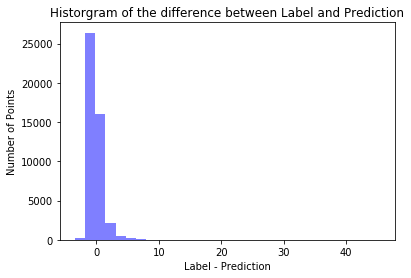

Total Points is: 45623
Total Points between -1 to 1 is: 38118


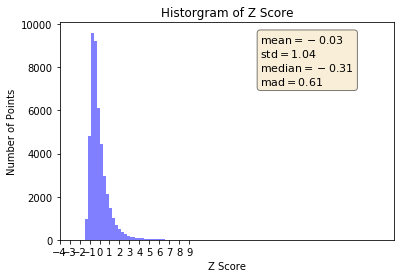

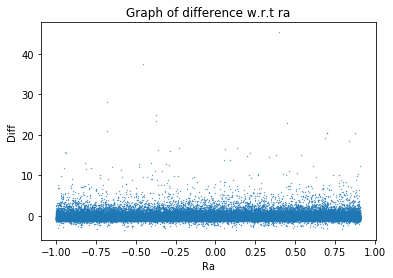

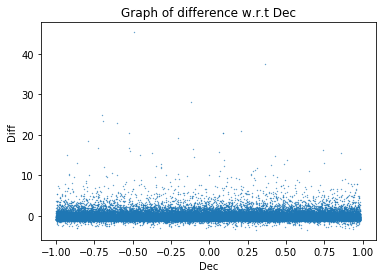

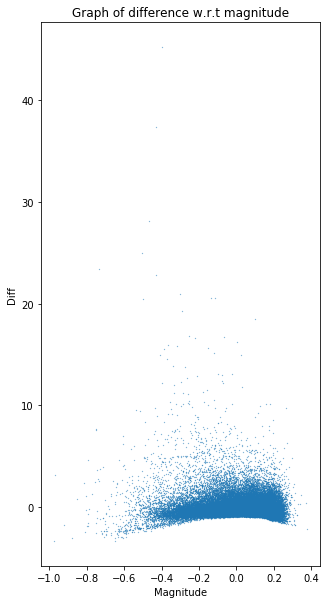

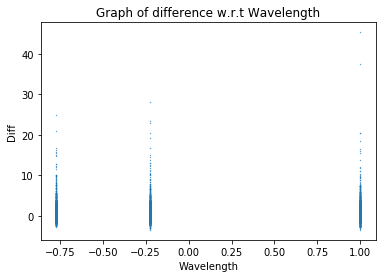

In [0]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import stats

x, y, mu, sigma, tpe = np_test(test_data_loader, neuralprocess, test_parallax_error)

#reshape to (size,)
np_y = np.reshape(y, y.shape[0])
np_mu = np.reshape(mu, mu.shape[0])
np_sigma = np.reshape(sigma, sigma.shape[0])
np_tpe = np.reshape(tpe, tpe.shape[0])

np_ra = x.T[0]
np_dec = x.T[1]
np_mag = x.T[2]
np_wav = x.T[3]

# calculate diff
diff = np_y - np_mu
#convert numpy array into list
print("Total Points is: {}".format(y.shape[0]))
ls_y = list(np.reshape(y, y.shape[0]))
ls_mu = list(np.reshape(mu, mu.shape[0]))
ls_diff = list(diff)
ls_sigma = list(np_sigma)

ls_ra = list(np_ra)
ls_dec = list(np_dec)
ls_mag = list(np_mag)
ls_wav = list(np_wav)
            
plt.xlabel('Label - Prediction')
plt.ylabel('Number of Points')
plt.title(r'Historgram of the difference between Label and Prediction')


num_bins = 30
n, bins, patches = plt.hist(ls_diff, num_bins, facecolor='blue', alpha=0.5)

plt.show()

#plot z score

z_score= (np_y- np_mu)/np_sigma
zscore_std = np.std(z_score)
zscore_mean = np.mean(z_score)
zscore_median = np.median(z_score)
zscore_mad = stats.median_absolute_deviation(z_score)

textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$' % (zscore_mean, ),
    r'$\mathrm{std}=%.2f$' % (zscore_std, ),
    r'$\mathrm{median}=%.2f$' % (zscore_median, ),
    r'$\mathrm{mad}=%.2f$' % (zscore_mad , )))

fig, ax = plt.subplots()

ls_z_score = list(z_score)
count_ZeroToOne = len([i for i in ls_z_score if i <= 1 and i>= -1]) 
plt.xlabel('Z Score')
plt.ylabel('Number of Points')
plt.title(r'Historgram of Z Score')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)


print("Total Points is: {}".format(y.shape[0]))
print("Total Points between -1 to 1 is: {}".format(count_ZeroToOne))

num_bins = 100
n, bins, patches = plt.hist(ls_z_score, num_bins, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(-4, 10, step=1))

plt.show()

# ra
x = ls_ra
y = ls_diff
plt.scatter(x,y, s=0.1)
plt.xlabel('Ra')
plt.ylabel('Diff')
plt.title(r'Graph of difference w.r.t ra')

plt.show()

# dec
x = ls_dec
y = ls_diff
plt.scatter(x,y, s=0.1)
plt.xlabel('Dec')
plt.ylabel('Diff')
plt.title(r'Graph of difference w.r.t Dec')

plt.show()

# magnitude
x = ls_mag
y = ls_diff
plt.figure(figsize=(5,10)) 
plt.scatter(x,y, s=0.05)
plt.xlabel('Magnitude')
plt.ylabel('Diff')
plt.title(r'Graph of difference w.r.t magnitude')
plt.show()

# wavelength
x = ls_wav
y = ls_diff
plt.scatter(x,y, s=0.1)
plt.xlabel('Wavelength')
plt.ylabel('Diff')
plt.title(r'Graph of difference w.r.t Wavelength')

plt.show()

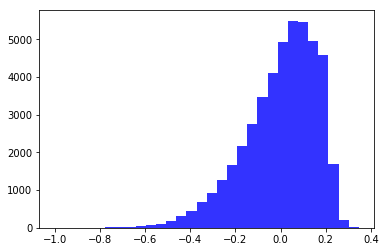

In [0]:
#histogram of magnitude
num_bins = 30
n, bins, patches = plt.hist(ls_mag, num_bins, facecolor='blue', alpha=0.8)

[ 0.33062544 -1.1037427   0.8413819  ... -0.56499046  0.0141535
  0.9181719 ]


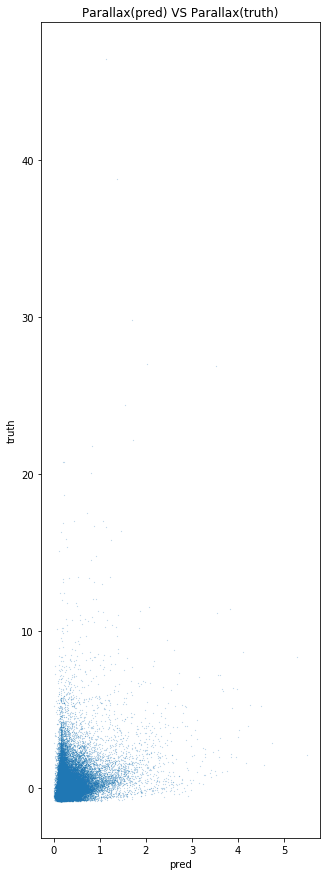

In [0]:

x = ls_mu
y = ls_y

print(np_mu-np_y)
plt.figure(figsize=(5,15)) 
plt.scatter(x,y, s=0.01)
plt.xlabel('pred')
plt.ylabel('truth')
plt.title(r'Parallax(pred) VS Parallax(truth)')
plt.show()


sigma(pred)/sigma(truth)  VS  Parallax(truth)

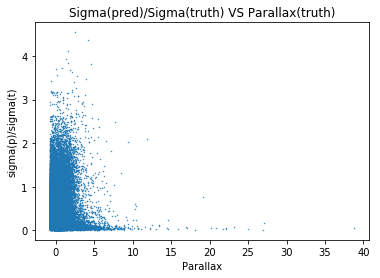

In [0]:
x = ls_y
y = list(np_tpe / np_sigma)

plt.scatter(x,y, s=0.2)
plt.xlabel('Parallax')
plt.ylabel('sigma(p)/sigma(t)')
plt.title(r'Sigma(pred)/Sigma(truth) VS Parallax(truth)')

plt.show()

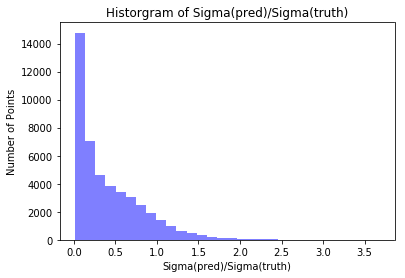

In [0]:
plt.xlabel('Sigma(pred)/Sigma(truth)')
plt.ylabel('Number of Points')
plt.title(r'Historgram of Sigma(pred)/Sigma(truth)')

y = list(np_tpe / np_sigma)
num_bins = 30
n, bins, patches = plt.hist(y, num_bins, facecolor='blue', alpha=0.5)

plt.show()